# Exemplary workflow for figure 5 (PRDM13)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import logomaker
import sys
import numpy as np
import os
import scipy.stats 

In [2]:
def save_matrix_as_meme(matrix, filename, protein_name):
    with open(filename, 'w') as file:
        # First four lines
        file.write("MEME version 5.5\n")
        file.write("ALPHABET= ACGT\n")
        file.write("\n")
        file.write(f"MOTIF {protein_name}\n")
        
        # Dimensions of the matrix
        alength = 4
        #alength = len(matrix[0])
        w = len(matrix)
        file.write(f"letter-probability matrix: alength= {alength} w= {w}\n")
        
        # Writing the matrix
        for index in range(len(matrix)):
            file.write(" ".join(map(str, matrix.iloc[index,])) + "\n")

In [3]:
def append_symmetric_rows(df):
    # Create new rows with all values as 0.25
    new_rows = pd.DataFrame({col: [0.25] * len(df.columns) for col in df.columns})

    # Append new rows to the top and bottom of the dataframe
    df = pd.concat([new_rows, df, new_rows], ignore_index=True)

    # Ensure dataframe length is 20
    while len(df) < 20:
        df = pd.concat([new_rows, df, new_rows], ignore_index=True)

    # Trim excess rows if necessary
    df = df.iloc[:20]

    return df

In [4]:
# Filter out all WGBS reads which have insufficient coverage so that the average
# coverage of the dataset is 15x. (Ziller et al. 2015)

def find_optimal_coverage(df):
    if len(df) == 0:
        return df
    else:
        cutoff = 2
        average = 0
        while average <= 15:
            df = df[df['coverage'] >= cutoff]
            try: 
                average = sum(df['coverage'])/len(df)
            except ZeroDivisionError:
                used_cutoff = cutoff
                return df, used_cutoff
            
            used_cutoff = cutoff
            cutoff += 1
        return df, used_cutoff

In [5]:
# Number of bootstrap samples
n_bootstrap = 1000

# Number of data points per sample
n_points = 1000

# Function to generate bootstrap samples
def bootstrap_sample(data, n):
    return data.sample(n=n, replace=True)['percent_methylation'].values

# Function to calculate the mean and confidence intervals
def calculate_statistics(samples):
    median = np.median(samples, axis=0)
    lower_bound = np.min(samples, axis=0)
    upper_bound = np.max(samples, axis=0)
    return median, lower_bound, upper_bound

In [6]:
def bootstrap_pipeline(df1, df2, df3, df4=None, n_bootstrap=1000, n_points=1000, return_only_median=True):
    bootstrap_samples1 = np.zeros((n_bootstrap, n_points))
    bootstrap_samples2 = np.zeros((n_bootstrap, n_points))
    bootstrap_samples3 = np.zeros((n_bootstrap, n_points))
    
    # Bootstrap loop

    for i in range(n_bootstrap):
        bootstrap_samples1[i] = bootstrap_sample(df1, n_points)
        bootstrap_samples2[i] = bootstrap_sample(df2, n_points)
        bootstrap_samples3[i] = bootstrap_sample(df3, n_points)

    if df4 is not None:
        bootstrap_samples4 = np.zeros((n_bootstrap, n_points))
        for i in range(n_bootstrap):
            bootstrap_samples4[i] = bootstrap_sample(df4, n_points)
        # Combine all bootstrap samples if df4 is provided
        combined_array = np.concatenate((bootstrap_samples1, bootstrap_samples2, bootstrap_samples3, bootstrap_samples4), axis=0)
    else:
        # Combine only df1, df2, and df3 bootstrap samples if df4 is not provided
        combined_array = np.concatenate((bootstrap_samples1, bootstrap_samples2, bootstrap_samples3), axis=0)

    # ECDF calculation
    x = np.sort(combined_array)

    # Calculate statistics
    median, lower_bound, upper_bound = calculate_statistics(x)
    
    if return_only_median:
        return median
    else:
        return median, lower_bound, upper_bound

In [7]:
def check_p_values(p1, p2, p3, p4, p5):
    p_values = [p1, p2, p3, p4, p5]
    
    # Check if any value is larger than 0.05
    if any(p > 0.05 for p in p_values):
        return '> 0.05, no significant difference'
        
    # If all are smaller, find the largest and return in scientific notation
    largest_p = max(p_values)
    return f'< {largest_p:.2e}'

In [ ]:
sys.path.append('../meSMiLEseq/scripts/')

`sys.path.append('path_to_functions_file')`

In [11]:
import functions

Here you need to load your motif of choice, if it is a PSAM first it needs to be transformed to a ppm. If it is already a ppm you can immediatly run save_matrix_as_meme to write it in the .meme format (necessary for fimo). All motifs were stretched to 20 bp to reduce the number of false discoveries (append_symmetric_rows).  
  
PRDM13 binds to both methylated and unmethylated DNA according to meSMiLE-seq data. Using ChIP-seq data provided by Codebook (overexpressed TF in HEK293T cells) one can verify if this holds true in a cellular context.
  
The motif was loaded as PSAM.

`df_bs2 = pd.read_csv('psam.csv')`

In [7]:
df_bs2 = pd.read_csv('PRDM13_DBD_bindingmode_1.csv', index_col=0)

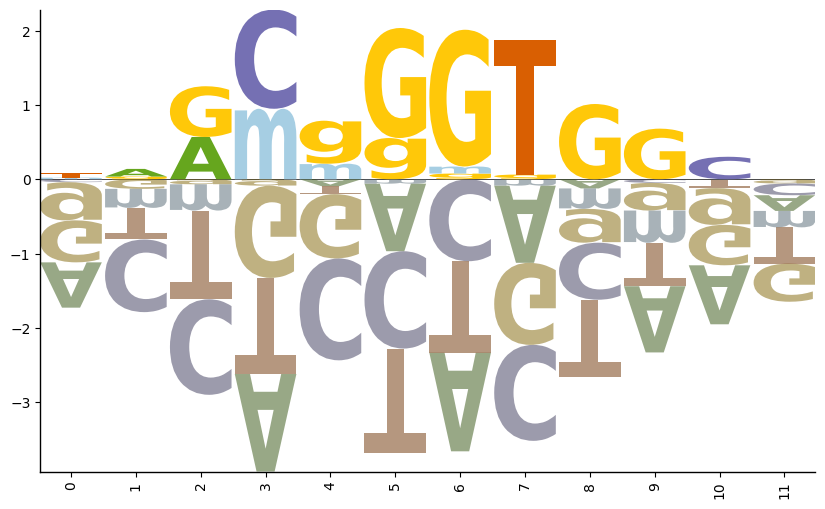

In [8]:
fig, ax = plt.subplots(1,1,figsize=[10,6])

logo = logomaker.Logo(df_bs2,
                        shade_below=0.5,
                        ax=ax,
                        fade_below=0.5,
                        color_scheme={'A':'#66a61e', 'C':'#7570b3','G':'#ffc809','T':'#d95f02','m':'#a6cee3'},
                        #baseline_width=0
                        )

# style using Logo methods
logo.style_spines(visible=False)
logo.style_spines(spines=['left', 'bottom'], visible=True)
logo.style_xticks(rotation=90, fmt='%d', anchor=0)
#logo.ax.set_xticks([])
#logo.ax.set_yticks([])

plt.show()

The model predicts that PRDM13 has a high affinity towards methylated 'CG' in the 3rd and 4th position which is not the case if CG is unmethylated. However, the protein seems to as well accept a 'CA' at the aformentioned position; both observation have been validated via EMSA. To verify whether the TF has similar binding pattern in cells, one can extract the information from the PSAM, convert the matrix into a .meme format (no extended alphabet) and replace the values for CG with the values for mg at position 3 and 4.

In [9]:
# convert PSAM into PPM
    
# First get mu's
mean_values = df_bs2.max(axis=1)



df_bs2_m = df_bs2.add(-mean_values, axis='rows')



# ProBound uses ln
psam = np.e**(df_bs2_m)



# Now let's simulate the frequencies, creating the postion frequency matrix 
pfm = psam * 10000 #(this step is fully redundant and can be skipped)
pfm = pfm.T



# Drop 'mg' to extract unmethylated motif
pfm_unmetylated = pfm.drop(['m', 'g'])

probs_unmethylated = my_functions.pfm_to_ppm(pfm_unmetylated)

In [10]:
# Swap 'mg' with 'CG' at the 3rd and 4th position to extract the methyl plus motif
pfm.loc['C'][3] = pfm.loc['m'][3]
pfm.loc['G'][4] = pfm.loc['g'][4]

In [11]:
# DROP M and G since it makes it impossible to compare to other datasets using standard tools
pfm = pfm.drop(['m', 'g'])

probs = my_functions.pfm_to_ppm(pfm)

By default stretch the motif to a window of 20 bp using background sequences.

In [12]:
long_methylated = append_symmetric_rows(probs.T)
long_unmethylated = append_symmetric_rows(probs_unmethylated.T)

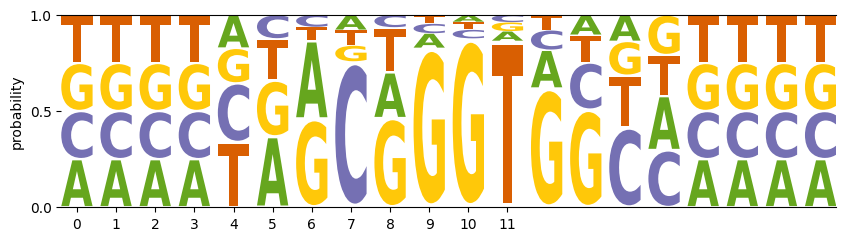

In [13]:
fig, ax = plt.subplots(1,1,figsize=[10,2.5])
logo = logomaker.Logo(long_methylated,
                    ax=ax,
                    width=.8,
                    vpad=.05,
                    fade_probabilities=False,
                    stack_order='small_on_top',
                    color_scheme={'A':'#66a61e', 'C':'#7570b3','G':'#ffc809','T':'#d95f02','m':'#a6cee3'}
                    )
# style using Logo methods
logo.style_spines(spines=['left', 'right'], visible=False)


# style using Axes methods
logo.ax.set_ylabel('probability')
logo.ax.set_yticks([0, .5, 1])
logo.ax.set_xticks(range(len(probs.T)))


#fig.savefig("meme_motif_methylated.pdf", format='pdf')

plt.show()
#plt.close()


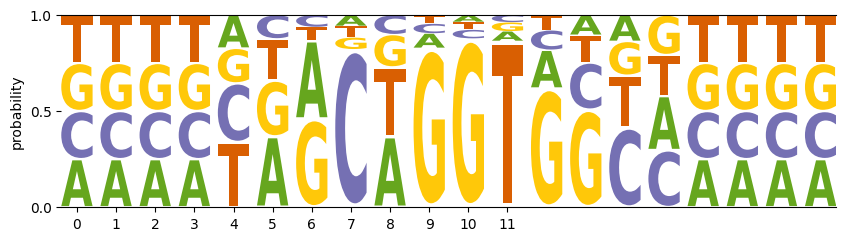

In [14]:
fig, ax = plt.subplots(1,1,figsize=[10,2.5])
logo = logomaker.Logo(long_unmethylated,
                    ax=ax,
                    width=.8,
                    vpad=.05,
                    fade_probabilities=False,
                    stack_order='small_on_top',
                    color_scheme={'A':'#66a61e', 'C':'#7570b3','G':'#ffc809','T':'#d95f02','m':'#a6cee3'}
                    )
# style using Logo methods
logo.style_spines(spines=['left', 'right'], visible=False)


# style using Axes methods
logo.ax.set_ylabel('probability')
logo.ax.set_yticks([0, .5, 1])
logo.ax.set_xticks(range(len(probs.T)))


#fig.savefig("meme_motif_unmethylated.pdf", format='pdf')

plt.show()

Next, to run fimo one needs the DNA sequences extracted from the PRDM13.bed file.

`$ bedtools getfasta -fi hg19.fa -bed my_peak_bedfile.bed -fo PRDM13.fa`

Then, search for the motifs in the PRDM13.fa file using the default parameters (keep all hits with a p-value <0.0001).
In this analysis the top 1000 best hits were considered (PRDM13 methyl, average FDR = 3.78 %; PRDM13 unmethylated, average FDR = 1.18 %).


`$ fimo -o fimo_out PRDM13_methyl.meme PRDM13.fa`  
`$ fimo -o fimo_out PRDM13_unmethyl.meme PRDM13.fa`  


`$ head -n 1000 best_site_methylated.narrowPeak > top1k_m.narrowPeak`  
`$ head -n 1000 best_site_unmethylated.narrowPeak > top1k_um.narrowPeak`
 
Intersect with ChromHMM annotations for 293T cells and with WGBS data using bedtools intersect.  

(Note: when intersecting with WGBS data one can define a 'core' region and flanks. For PRDM13 the core is between position  3 and 11 --> generate two .narrowPeak files with genomic positions defining core and flanks.)
  
`$ bedtools intersect -a WGBS.bed.gz -b core_motif.narrowPeak -f 1 > methylation_status_core.bed`  

(Note: -f 1 forces bedtools to only match full dinucleotides. It avoids 'spilling in' if CG is at the boundary of the core region.)  

`$ bedtools intersect -a WGBS.bed.gz -b flank.narrowPeak -wa > methylation_status_flank.bed` 

## Checking methylation status

The WGBS data contains standard bed9+2 information (see ENCODE).

In [8]:
colnames = ['chr', 'start', 'end', 'name', 'score_0-1000', 'strand', 
            'startcodon', 'endcodon', 'rgb_val', 'coverage', 'percent_methylation']

Load data (in publication average of 3 replicates was used), the PRDM13 unmethylation core didn't contain any CG dinucleotides.

`df = pd.read_csv('path_to/FDR10.bed', sep='\t', header=None)`

In [9]:
folder_path = 'WGBS/'
TF_name = 'PRDM13_methyl'

Coverage at motifs:  15.34


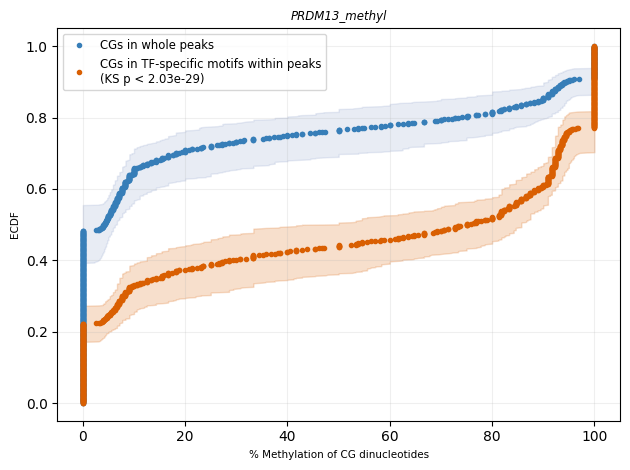

In [10]:
filename1 = 'WGBS_core_motif/' + TF_name + '_WGBS_Rep1.bed'
filename2 = 'WGBS_core_motif/' + TF_name + '_WGBS_Rep2.bed'
filename3 = 'WGBS_core_motif/' + TF_name + '_WGBS_Rep3.bed'
            

df1 = pd.read_csv(os.path.join(folder_path, filename1), sep='\t', header=None)
df1.columns = colnames
df1, cutoff1 = find_optimal_coverage(df1)
coverage1 = sum(df1['coverage'])/len(df1)

df2 = pd.read_csv(os.path.join(folder_path, filename2), sep='\t', header=None)
df2.columns = colnames
df2, cutoff2 = find_optimal_coverage(df2)
coverage2 = sum(df2['coverage'])/len(df2)

df3 = pd.read_csv(os.path.join(folder_path, filename3), sep='\t', header=None)
df3.columns = colnames
df3, cutoff3 = find_optimal_coverage(df3)
coverage3 = sum(df3['coverage'])/len(df3)

average_coverage = round((coverage1 + coverage2 + coverage3) / 3, 3)
print('Coverage at motifs: ', average_coverage)


#bootstrapping, 1000 times, 1000 samples
median, upper_bound, lower_bound = bootstrap_pipeline(df1, df2, df3, n_bootstrap=1000, n_points=1000, return_only_median=False)
            
#Loading data for whole peaks
peak_rep1 = 'WGBS_peak/' + TF_name + '_wholepeak_WGBS_Rep1.bed'
peak_rep2 = 'WGBS_peak/' + TF_name + '_wholepeak_WGBS_Rep2.bed'
peak_rep3 = 'WGBS_peak/' + TF_name + '_wholepeak_WGBS_Rep3.bed'
                
peak1 = pd.read_csv(os.path.join(folder_path, peak_rep1), sep='\t', header=None)
peak1.columns = colnames
peak1, cutoff = find_optimal_coverage(peak1)
                
peak2 = pd.read_csv(os.path.join(folder_path, peak_rep2), sep='\t', header=None)
peak2.columns = colnames
peak2, cutoff = find_optimal_coverage(peak2)
                
peak3 = pd.read_csv(os.path.join(folder_path, peak_rep3), sep='\t', header=None)
peak3.columns = colnames
peak3, cutoff = find_optimal_coverage(peak3)
            
# bootstrapping again
r_median, r_upper_bound, r_lower_bound = bootstrap_pipeline(peak1, peak2, peak3, n_bootstrap=1000, n_points=1000, return_only_median=False)
                
# Performing KS test for p_value calculation
statistic, p_value = scipy.stats.ks_2samp(median, r_median)
statistic2, p_value2 = scipy.stats.ks_2samp(median, r_lower_bound)
statistic3, p_value3 = scipy.stats.ks_2samp(median, r_upper_bound)
statistic4, p_value4 = scipy.stats.ks_2samp(r_median, lower_bound)
statistic5, p_value5 = scipy.stats.ks_2samp(r_median, upper_bound)
                
t = check_p_values(p_value, p_value2, p_value3, p_value4, p_value5)
    

# Plotting ECDF
                
y_1 = np.arange(1, len(r_median) + 1) / len(r_median)
y_2 = np.arange(1, len(median) + 1) / len(median)
    
plt.plot(r_median, y_1, marker='.', color='#377eb8', linestyle='none', label=f'CGs in whole peaks')
plt.plot(median, y_2, marker='.', color='#d95f02', linestyle='none', label=f'CGs in TF-specific motifs within peaks\n(KS p {t})')
                
plt.fill_betweenx(y_1, r_lower_bound, r_upper_bound, color='#8da0cb', alpha=0.2)
plt.fill_betweenx(y_2, lower_bound, upper_bound, color='#d95f02', alpha=0.2)
                
plt.grid(alpha=0.2)
                
# Add labels and legend
plt.title(f'{TF_name}', fontstyle='italic', fontsize=8.5)
plt.xlabel('% Methylation of CG dinucleotides', fontsize=7.5)
plt.ylabel('ECDF', fontsize=7.5)
plt.legend(fontsize="small")
    
plt.tight_layout()

#plt.savefig('PRDM13_methyl.pdf', format='pdf')

plt.show()

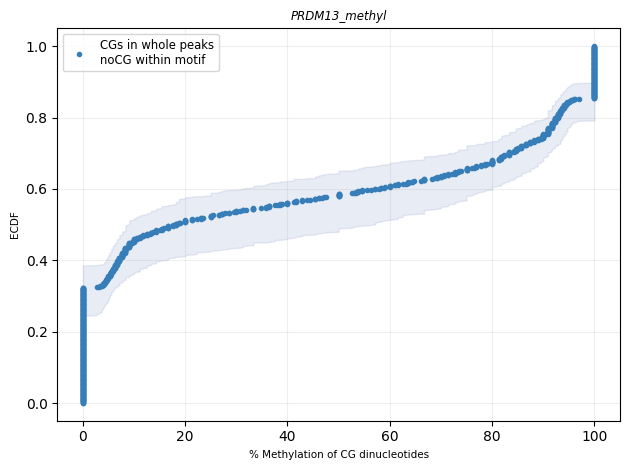

In [11]:
#Loading data for whole peaks, PRDM13 unmethylated motif
peak_rep1 = 'WGBS_peak/PRDM13_unmethyl_wholepeak_WGBS_Rep1.bed'
peak_rep2 = 'WGBS_peak/PRDM13_unmethyl_wholepeak_WGBS_Rep2.bed'
peak_rep3 = 'WGBS_peak/PRDM13_unmethyl_wholepeak_WGBS_Rep3.bed'
                
peak1 = pd.read_csv(os.path.join(folder_path, peak_rep1), sep='\t', header=None)
peak1.columns = colnames
peak1, cutoff = find_optimal_coverage(peak1)
                
peak2 = pd.read_csv(os.path.join(folder_path, peak_rep2), sep='\t', header=None)
peak2.columns = colnames
peak2, cutoff = find_optimal_coverage(peak2)
                
peak3 = pd.read_csv(os.path.join(folder_path, peak_rep3), sep='\t', header=None)
peak3.columns = colnames
peak3, cutoff = find_optimal_coverage(peak3)
            
# bootstrapping again
r_median, r_upper_bound, r_lower_bound = bootstrap_pipeline(peak1, peak2, peak3, n_bootstrap=1000, n_points=1000, return_only_median=False)

    

# Plotting ECDF
                
y_1 = np.arange(1, len(r_median) + 1) / len(r_median)

    
plt.plot(r_median, y_1, marker='.', color='#377eb8', linestyle='none', label=f'CGs in whole peaks\nnoCG within motif')

                
plt.fill_betweenx(y_1, r_lower_bound, r_upper_bound, color='#8da0cb', alpha=0.2)

                
plt.grid(alpha=0.2)
                
# Add labels and legend
plt.title(f'{TF_name}', fontstyle='italic', fontsize=8.5)
plt.xlabel('% Methylation of CG dinucleotides', fontsize=7.5)
plt.ylabel('ECDF', fontsize=7.5)
plt.legend(fontsize="small")
    
plt.tight_layout()

#plt.savefig('PRDM13_unmethyl.pdf')

plt.show()

# Check methylation status for exemplary CG position in figure 5

In [12]:
TF_name = 'PRDM13_methyl'
folder_path = 'WGBS/'

In [13]:
filename1 = 'WGBS_core_motif/' + TF_name + '_WGBS_Rep1.bed'
filename2 = 'WGBS_core_motif/' + TF_name + '_WGBS_Rep2.bed'
filename3 = 'WGBS_core_motif/' + TF_name + '_WGBS_Rep3.bed'

df1 = pd.read_csv(os.path.join(folder_path, filename1), sep='\t', header=None)
df1.columns = colnames
#df1, cutoff1 = find_optimal_coverage(df1)

df2 = pd.read_csv(os.path.join(folder_path, filename2), sep='\t', header=None)
df2.columns = colnames
#df2, cutoff2 = find_optimal_coverage(df2)

df3 = pd.read_csv(os.path.join(folder_path, filename3), sep='\t', header=None)
df3.columns = colnames
#df3, cutoff3 = find_optimal_coverage(df3)

In [14]:
percent_methl = []
cover = []

for i, df_replicate in enumerate([df1, df2, df3]):
    chrom = df_replicate[df_replicate['chr'] == 'chr18']
    pos = chrom[(chrom['start'] > 21422460) & (chrom['end'] < 21422475)]
    percent_methl.append(pos['percent_methylation'].values[0])
    cover.append(pos['coverage'].values[0])


In [15]:
np.mean(percent_methl)

100.0

In [16]:
np.std(percent_methl)

0.0

In [17]:
np.mean(cover)

10.666666666666666

In [18]:
df1[df1['chr'] == 'chr18']

,chr,start,end,name,score_0-1000,strand,startcodon,endcodon,rgb_val,coverage,percent_methylation
1532,chr18,2655700,2655702,.,11,+,2655700,2655702,.,11,0.0000
1533,chr18,2655700,2655702,.,2,-,2655700,2655702,.,2,0.0000
1534,chr18,9914089,9914091,.,21,+,9914089,9914091,.,21,0.0000
1535,chr18,9914089,9914091,.,16,-,9914089,9914091,.,16,0.0000
1536,chr18,11908502,11908504,.,8,+,11908502,11908504,.,8,0.0000
1537,chr18,11908502,11908504,.,18,-,11908502,11908504,.,18,0.0000
1538,chr18,18806567,18806569,.,13,+,18806567,18806569,.,13,92.3077
1539,chr18,18806567,18806569,.,13,-,18806567,18806569,.,13,100.0000
1540,chr18,21106513,21106515,.,11,+,21106513,21106515,.,11,72.7273
1541,chr18,21106513,21106515,.,9,-,21106513,21106515,.,9,22.2222


In [19]:
df2[df2['chr'] == 'chr18']

,chr,start,end,name,score_0-1000,strand,startcodon,endcodon,rgb_val,coverage,percent_methylation
1532,chr18,2655700,2655702,.,13,+,2655700,2655702,.,13,0.0000
1533,chr18,2655700,2655702,.,3,-,2655700,2655702,.,3,0.0000
1534,chr18,9914089,9914091,.,23,+,9914089,9914091,.,23,0.0000
1535,chr18,9914089,9914091,.,14,-,9914089,9914091,.,14,0.0000
1536,chr18,11908502,11908504,.,13,+,11908502,11908504,.,13,0.0000
1537,chr18,11908502,11908504,.,19,-,11908502,11908504,.,19,10.5263
1538,chr18,18806567,18806569,.,15,+,18806567,18806569,.,15,93.3333
1539,chr18,18806567,18806569,.,10,-,18806567,18806569,.,10,90.0000
1540,chr18,21106513,21106515,.,6,+,21106513,21106515,.,6,50.0000
1541,chr18,21106513,21106515,.,7,-,21106513,21106515,.,7,57.1429


In [20]:
df3[df3['chr'] == 'chr18']

,chr,start,end,name,score_0-1000,strand,startcodon,endcodon,rgb_val,coverage,percent_methylation
1539,chr18,2655700,2655702,.,16,+,2655700,2655702,.,16,0.00000
1540,chr18,2655700,2655702,.,5,-,2655700,2655702,.,5,0.00000
1541,chr18,9914089,9914091,.,33,+,9914089,9914091,.,33,0.00000
1542,chr18,9914089,9914091,.,20,-,9914089,9914091,.,20,0.00000
1543,chr18,11908502,11908504,.,24,+,11908502,11908504,.,24,4.16667
1544,chr18,11908502,11908504,.,19,-,11908502,11908504,.,19,5.26316
1545,chr18,18806567,18806569,.,23,+,18806567,18806569,.,23,95.65220
1546,chr18,18806567,18806569,.,12,-,18806567,18806569,.,12,100.00000
1547,chr18,21106513,21106515,.,23,+,21106513,21106515,.,23,69.56520
1548,chr18,21106513,21106515,.,12,-,21106513,21106515,.,12,58.33330
